<a href="https://colab.research.google.com/github/matician255/NEURAL-NETWORK-FLASHCARDS/blob/main/Mini_micrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [113]:
import math
class Value:  #THIS IS LIKE A BLLUEPRINT FOR CREATING OBJECTS THAT WORK WITH DATA
    """
    self: refers to the object created
    data: the value that is passed when an object is created
    """
    def __init__(self, data, _children=(), _op="", label=''): # this is a constructor method that automatically runs when an object is created
        self.data = data     # this stores the value inside an object
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self): # this defines how the object should be representated(string representation ) when printing the output
        return f"Value(data={self.data})"

    def __add__(self, other): # is like a magic method that defines how + operator works for Value objects
        other = other if isinstance (other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")


        def _backward():
          self.grad += 1.0 * out.grad
          other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __radd__(self, other):
      return self + other


    def __neg__(self):
      return self * -1

    def __sub__(self, other):
      return self + (-other)

    def __pow__(self, other):
      assert isinstance(other, (int, float)), "only supporting integers/float for now"
      out = Value(self.data**other, (self, ), f'**{other}')

      def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
      out._backward = _backward

      return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")


        def _backward():
          self.grad += other.data * out.grad
          other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
      return self * other**-1

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
          self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def exp(self):
      x = self.data
      out = Value(math.exp(x), (self, ), 'exp')

      def _backward():
        self.grad += out.data * out.grad
      out._backward = _backward

      return out


    def backward(self):

      topo = []
      visited = set()
      def build_topo(v):
        if v not in visited:
          visited.add(v)
          for child in v._prev:
            build_topo(child)
          topo.append(v)
      build_topo(self)
      self.grad = 1.0

      for node in reversed(topo):
        node._backward()







In [108]:
# !pip install graphviz

from graphviz import Digraph

def trace(root):   # Finds all nodes and edges in the computation graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):  # Uses Graphviz to draw a visual graph
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # layout goes Left to Right (instead of top to bottom)

    nodes, edges = trace(root)  #Get all nodes and edges
    for n in nodes: #Loop through nodes and draw them
        uid = str(id(n))  # gives a unique ID for each node (based on memory address)
        dot.node(name = uid, label = "{%s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad ), shape= 'record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:  #draw the edges From input node n1 To the operation node that created n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot  #returns the Graphviz object so you can render or display it.

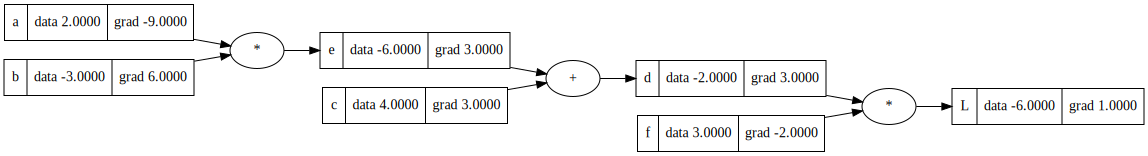

In [ ]:
draw_dot(L)

In [114]:
import torch


x1 = torch.Tensor([2.0]).double()  ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()  ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()  ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()  ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('_____')
print('x2' , x2.grad.item())
print('w2' , w2.grad.item())
print('x1' , x1.grad.item())
print('w2' , w2.grad.item())


0.7071066904050358
_____
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w2 0.0


In [156]:
from typing_extensions import ParamSpec
import numpy as np
import random

class Neuron:
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1, 1))

  def __call__(self, x):
    act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:
  def  __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]



class MLP:
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]




In [157]:
n = MLP(3, [4, 4, 1])

In [167]:
xs=[[ 1.8,  0.8,  2.5],
 [ 1. ,  1.4,  0.9],
 [ 2.7,  0.8, -0.7],
 [ 2.5, -0.4,  2.4]]

ys =[-1.,  1.,  1., -1.]


In [168]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for yout, ygt in zip(ypred, ys))
loss

Value(data=4.707476091125859)

In [218]:
for k in range(30):
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for yout, ygt in zip(ypred, ys))

  #backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  #update the parameters
  for p in n.parameters():
    p.data += -0.05 * p.grad

  print(k, loss.data)


0 0.002804610035181428
1 0.0027960242347275775
2 0.002787488921494568
3 0.0027790036579631553
4 0.0027705680116144374
5 0.0027621815548590093
6 0.002753843864967243
7 0.0027455545240008166
8 0.002737313118745377
9 0.0027291192406443477
10 0.0027209724857337374
11 0.0027128724545782495
12 0.0027048187522081624
13 0.002696810988057582
14 0.0026888487759033817
15 0.0026809317338054375
16 0.0026730594840477036
17 0.002665231653080234
18 0.0026574478714622178
19 0.0026497077738059215
20 0.0026420109987215262
21 0.002634357188762905
22 0.0026267459903742112
23 0.002619177053837401
24 0.002611650033220523
25 0.0026041645863269054
26 0.0025967203746451455
27 0.0025893170632998574
28 0.0025819543210032366
29 0.0025746318200073953


In [219]:
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.9709047586816484),
 Value(data=0.9723843489578956),
 Value(data=0.9772344641694489),
 Value(data=-0.9790256736805938)]